# Grouped by NPI then States

In [ ]:
# Data frame created by subsecting the original data to include only female M.D.s working in a facility that participates in Medicare and practices Diagnostic Radiology, 
# The data was then grouped by individual (NPI) and then by state
# K means was executed on the mean request from medicare and payment recieved as well as the percent recieved (payment/request)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

#import seaborn as sns
#import gc

In [3]:
#Import data 
missing_values = ["n/a", "na", "--"]
medicaredf = pd.read_csv("Medicare_Provider_Util_Payment_PUF_CY2017.txt",sep='	',na_values = missing_values)
print(medicaredf.head())

#Understanding basic info about data

medicaredf.columns #26 columns
medicaredf.shape #9,847,444 rows
medicaredf.info()
medicaredf.describe()
print(medicaredf.isnull().sum())
#remove outliers (amount requested from medicare should never be smaller than the amount recieved)
medicaredf["percentage"]=medicaredf['average_Medicare_payment_amt']/medicaredf['average_submitted_chrg_amt']
medicaredf=medicaredf[medicaredf["percentage"]<1]
print(medicaredf.head())

/Users/anna2/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


          npi                       nppes_provider_last_org_name  \
0           1  CPT copyright 2016 American Medical Associatio...   
1  1003000126                                          ENKESHAFI   
2  1003000126                                          ENKESHAFI   
3  1003000126                                          ENKESHAFI   
4  1003000126                                          ENKESHAFI   

  nppes_provider_first_name nppes_provider_mi nppes_credentials  \
0                       NaN               NaN               NaN   
1                   ARDALAN               NaN              M.D.   
2                   ARDALAN               NaN              M.D.   
3                   ARDALAN               NaN              M.D.   
4                   ARDALAN               NaN              M.D.   

  nppes_provider_gender nppes_entity_code nppes_provider_street1  \
0                   NaN               NaN                    NaN   
1                     M                 I           

In [7]:
print(medicaredf.provider_type.unique())
medicaredf['provider_type'].value_counts()

['Internal Medicine' 'Pathology' 'Anesthesiology' 'Family Practice'
 'Obstetrics & Gynecology' 'General Surgery' 'Urology' 'Cardiac Surgery'
 'Physician Assistant' 'Physical Therapist in Private Practice'
 'Dermatology' 'Licensed Clinical Social Worker' 'Optometry'
 'Mass Immunizer Roster Biller' 'Physical Medicine and Rehabilitation'
 'Radiation Oncology' 'Infectious Disease' 'Orthopedic Surgery'
 'Certified Clinical Nurse Specialist' 'Endocrinology' 'Chiropractic'
 'Psychiatry' 'Diagnostic Radiology' 'Centralized Flu' 'Rheumatology'
 'General Practice' 'Neurology' 'Emergency Medicine' 'Nephrology'
 'Ophthalmology' 'Nurse Practitioner' 'Pulmonary Disease' 'Otolaryngology'
 'Plastic and Reconstructive Surgery' 'Psychologist, Clinical'
 'Cardiology' 'Ambulance Service Provider' 'Interventional Cardiology'
 'Gastroenterology' 'Hospitalist' 'Audiologist'
 'Certified Registered Nurse Anesthetist (CRNA)' 'Geriatric Medicine'
 'Neurosurgery' 'Interventional Radiology' 'Critical Care (Intensi

Diagnostic Radiology                   1241379
Internal Medicine                      1117800
Family Practice                         969066
Nurse Practitioner                      560201
Cardiology                              445072
                                        ...   
Dentist                                     69
Mammography Center                          53
Slide Preparation Facility                  40
Unknown Supplier/Provider Specialty         17
Medical Toxicology                           2
Name: provider_type, Length: 94, dtype: int64

In [4]:
## Create new dataframe of npi, state, Medicare amount requested, and amount paid (df)
df=medicaredf.iloc[: , [0, 4,5, 11,13, 14, 15,23, 24]].copy() 
df.columns= ["npi", "credentials","gender","state","caretype","participate", "facility","request", "payment"]
#Remove rows where state is NaN because exploring how the state/ region affects the medicare payments and missing state will create unknown data points
df = df[pd.notnull(df["state"])]
print(df.head(15))
#Remove rows where payment/request>1 because this means they recieved more than they asked for which should not be the case and these will be outliers
df["percentage"]=df["payment"]/df["request"]
df=df[df["percentage"]<1]
print(df.head(15))

           npi credentials gender state           caretype participate  \
1   1003000126        M.D.      M    MD  Internal Medicine           Y   
2   1003000126        M.D.      M    MD  Internal Medicine           Y   
3   1003000126        M.D.      M    MD  Internal Medicine           Y   
4   1003000126        M.D.      M    MD  Internal Medicine           Y   
5   1003000126        M.D.      M    MD  Internal Medicine           Y   
6   1003000126        M.D.      M    MD  Internal Medicine           Y   
7   1003000126        M.D.      M    MD  Internal Medicine           Y   
8   1003000126        M.D.      M    MD  Internal Medicine           Y   
9   1003000126        M.D.      M    MD  Internal Medicine           Y   
10  1003000126        M.D.      M    MD  Internal Medicine           Y   
11  1003000126        M.D.      M    MD  Internal Medicine           Y   
12  1003000134        M.D.      M    IL          Pathology           Y   
13  1003000134        M.D.      M    I

In [5]:
x=df.credentials.unique()
print(x)
print(x.size)

['M.D.' 'D.O.' 'MD' ... 'MA,' 'L.AC, PA-C' 'RN MSN HSA FNP-C']
15986


In [6]:
df = df[df['credentials'].str.contains('M.D.', na=False)]
df = df[df['gender'].str.contains('F', na=False)]
df = df[df['participate'].str.contains('Y', na=False)]
df = df[df['facility'].str.contains('F', na=False)]
print(df)

                npi credentials gender state                 caretype  \
462      1003002627        M.D.      F    TX  Obstetrics & Gynecology   
587      1003002841        M.D.      F    SC                Neurology   
588      1003002841        M.D.      F    SC                Neurology   
589      1003002841        M.D.      F    SC                Neurology   
590      1003002841        M.D.      F    SC                Neurology   
...             ...         ...    ...   ...                      ...   
9847086  1992996375        M.D.      F    WI            Endocrinology   
9847314  1992998009        M.D.      F    FL               Psychiatry   
9847315  1992998009        M.D.      F    FL               Psychiatry   
9847316  1992998009        M.D.      F    FL               Psychiatry   
9847317  1992998009        M.D.      F    FL               Psychiatry   

        participate facility      request     payment  percentage  
462               Y        F  1070.000000  174.842727  

In [111]:
print(df.caretype.unique())
df['caretype'].value_counts()

['Obstetrics & Gynecology' 'Neurology' 'Pulmonary Disease'
 'Internal Medicine' 'Anesthesiology' 'Ophthalmology'
 'Physical Medicine and Rehabilitation' 'Gastroenterology'
 'General Surgery' 'Psychiatry' 'Family Practice' 'Emergency Medicine'
 'Endocrinology' 'Diagnostic Radiology' 'Neurosurgery' 'Nephrology'
 'Radiation Oncology' 'Vascular Surgery' 'Otolaryngology'
 'Pediatric Medicine' 'Pathology' 'Rheumatology' 'Hospitalist'
 'Critical Care (Intensivists)' 'Infectious Disease' 'Hematology'
 'Geriatric Medicine' 'Cardiology' 'Cardiac Surgery' 'Hematology-Oncology'
 'Sports Medicine' 'Surgical Oncology' 'Urology'
 'Undefined Physician type' 'Medical Oncology'
 'Interventional Pain Management' 'Thoracic Surgery'
 'Interventional Cardiology' 'Orthopedic Surgery' 'Dermatology'
 'General Practice' 'Hospice and Palliative Care'
 'Interventional Radiology' 'Colorectal Surgery (Proctology)'
 'Hand Surgery' 'Plastic and Reconstructive Surgery' 'Pain Management'
 'Clinical Cardiac Electrophysi

Diagnostic Radiology                                66652
Internal Medicine                                   45655
Pathology                                           23582
Emergency Medicine                                  18755
Anesthesiology                                      16694
Family Practice                                     12871
Cardiology                                          11213
Gastroenterology                                     7352
General Surgery                                      6960
Neurology                                            6823
Psychiatry                                           6003
Pulmonary Disease                                    5299
Nephrology                                           5204
Radiation Oncology                                   4757
Ophthalmology                                        4574
Hospitalist                                          4460
Hematology-Oncology                                  4114
Infectious Dis

In [7]:
df = df[df['caretype'].str.contains('Diagnostic Radiology', na=False)]
print(df.head())

             npi credentials gender state              caretype participate  \
5087  1003027533        M.D.      F    TX  Diagnostic Radiology           Y   
5089  1003027533        M.D.      F    TX  Diagnostic Radiology           Y   
5090  1003027533        M.D.      F    TX  Diagnostic Radiology           Y   
5091  1003027533        M.D.      F    TX  Diagnostic Radiology           Y   
5092  1003027533        M.D.      F    TX  Diagnostic Radiology           Y   

     facility     request     payment  percentage  
5087        F  680.000000  128.848000    0.189482  
5089        F  166.072165   32.053402    0.193009  
5090        F   35.666667    7.109807    0.199340  
5091        F   42.033333    7.623333    0.181364  
5092        F  201.363636   40.196364    0.199621  


In [8]:
df=df.drop(columns=["credentials", "gender","participate", "facility", "percentage", "caretype"])

In [9]:
#Groups by npi and takes mean of request and payment
individual = df.groupby("npi")["request","payment"].mean()


#Creating a new state column to match the new df so that only one row state is saved for each npi
state=df.drop_duplicates(subset="npi", keep='first') 
state=state.iloc[: ,[0,1]].copy() 

#Fix index for both df
state=state.reset_index(drop=True)
individual=individual.reset_index(drop=True)
#print(individual)
#print(state)
#combine the two df
df = pd.concat([state,individual], axis=1, join='outer', ignore_index=True)
df.columns= ["npi", "state", "request", "payment"]
print(df)

             npi state     request    payment
0     1003027533    TX  139.588049  28.534483
1     1003063181    IL  182.833333  30.862344
2     1003084971    LA   82.724038  24.224287
3     1003094103    FL  235.800000  51.624333
4     1003135989    CA  192.096117  43.288206
...          ...   ...         ...        ...
2725  1992930390    NY   37.500000   8.389100
2726  1992932545    PA  391.000000  70.335833
2727  1992948749    NY  140.436580  43.511134
2728  1992954150    OH  156.523810  36.156718
2729  1992956494    IL  208.100452  42.100024

[2730 rows x 4 columns]


In [10]:
pd.get_dummies(df['state'],prefix='State')
#print(pd.get_dummies(medicaredf['nppes_provider_state'],prefix='State').head())
df = pd.concat([df,pd.get_dummies(df['state'])],axis=1)
print(df)
#Not dropping "state" because it is easier to compare categorically later

             npi state     request    payment  AK  AL  AR  AZ  CA  CO  ...  \
0     1003027533    TX  139.588049  28.534483   0   0   0   0   0   0  ...   
1     1003063181    IL  182.833333  30.862344   0   0   0   0   0   0  ...   
2     1003084971    LA   82.724038  24.224287   0   0   0   0   0   0  ...   
3     1003094103    FL  235.800000  51.624333   0   0   0   0   0   0  ...   
4     1003135989    CA  192.096117  43.288206   0   0   0   0   1   0  ...   
...          ...   ...         ...        ...  ..  ..  ..  ..  ..  ..  ...   
2725  1992930390    NY   37.500000   8.389100   0   0   0   0   0   0  ...   
2726  1992932545    PA  391.000000  70.335833   0   0   0   0   0   0  ...   
2727  1992948749    NY  140.436580  43.511134   0   0   0   0   0   0  ...   
2728  1992954150    OH  156.523810  36.156718   0   0   0   0   0   0  ...   
2729  1992956494    IL  208.100452  42.100024   0   0   0   0   0   0  ...   

      SD  TN  TX  UT  VA  VT  WA  WI  WV  WY  
0      0   0   1

In [11]:
#Removing non-US states - Commented out rows are due to previous subsections
#df = df[df.XX != 1]
#df = df[df.AA != 1]
#df = df[df.AP != 1]
#df = df[df.AS != 1]
df = df[df.GU != 1]
#df = df[df.MP != 1]
df = df[df.PR != 1]
#df = df[df.VI != 1]
#df = df[df.ZZ != 1]
df = df[df.DC != 1]
#state=df['state']

In [12]:
df=df.drop(columns=['GU','PR'])
df=df.reset_index(drop=True)
df=df.drop(df.columns[0], axis = 1) 
df=df.drop(df.columns[3:56], axis = 1) 
print(df)

     state     request    payment
0       TX  139.588049  28.534483
1       IL  182.833333  30.862344
2       LA   82.724038  24.224287
3       FL  235.800000  51.624333
4       CA  192.096117  43.288206
...    ...         ...        ...
2694    NY   37.500000   8.389100
2695    PA  391.000000  70.335833
2696    NY  140.436580  43.511134
2697    OH  156.523810  36.156718
2698    IL  208.100452  42.100024

[2699 rows x 3 columns]


In [13]:
df = df.groupby("state")["request","payment"].mean()

(array([ 2.,  3.,  6.,  8., 15.,  5.,  7.,  2.,  1.,  1.]),
 array([0.10266992, 0.12132758, 0.13998523, 0.15864289, 0.17730054,
        0.1959582 , 0.21461585, 0.2332735 , 0.25193116, 0.27058881,
        0.28924647]),
 <a list of 10 Patch objects>)

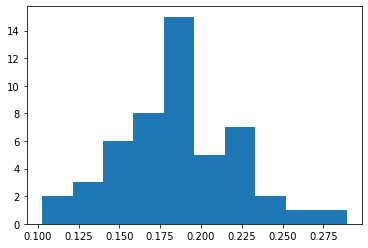

In [14]:
df["percentage"]=df["payment"]/df["request"]
plt.hist(df['percentage'])

In [15]:
#df.drop(['percentage'],axis=1,inplace=True)

In [16]:
scaler = preprocessing.StandardScaler().fit(df)
dfNorm = scaler.transform(df)

In [17]:
maxClusters = 50
sse = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm)
    sse.append(kmeans.inertia_)

In [140]:
print(sse)

[43.16033999298891, 30.814097372200255, 22.689896392390953, 18.726411617252047, 16.401835216792854, 13.99018973024963, 10.193829511517203, 8.255314946512566, 6.719895441652509, 5.705103753339495, 4.6276443868691155, 4.088941796988237, 3.382667946979496, 2.959733924960874, 2.580200959642531, 2.4293415114188557, 2.021151441369841, 1.8456644869209902, 1.6203477979587517, 1.521551544227946, 1.2387060010898772, 1.0871257833672874, 0.960451192129034, 0.8518940348831243, 0.6973226555868559, 0.6461347786721297, 0.5727915183525591, 0.47357748221129914, 0.4033887494706647, 0.3397648252805597, 0.28011147496915034, 0.246280790121252, 0.2142853546887743, 0.18216917413855532, 0.14981799499281478, 0.12257397384147459, 0.10271461468211385, 0.08390913123598667, 0.07762823507602681, 0.04726991225937671, 0.03220404578206601, 0.018062499601795567, 0.008696663222501575, 0.00513937713497961, 0.0036025997216947306, 0.002230463431246948, 0.0011520162405217699, 8.563656014768364e-05]


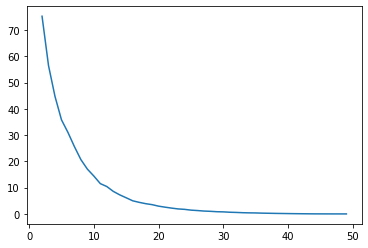

In [18]:
plt.plot(range(2,maxClusters),sse)

In [19]:
silh = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm)
    silhouette_avg = silhouette_score(dfNorm, kmeans.labels_)
    silh.append(silhouette_avg)
print(silh)

[0.44965500996130436, 0.3330152042670845, 0.32586060182691406, 0.32211336363739124, 0.35060478433122627, 0.33950266008111163, 0.3386002691160167, 0.3401192327590221, 0.34142382809237093, 0.36310840294791197, 0.3357890160784111, 0.3815760751960968, 0.3581138624050321, 0.3633887577079726, 0.374214459158996, 0.37371893458351624, 0.35126426907556957, 0.3585557433293677, 0.3634573792062632, 0.37818306679348834, 0.355955642840076, 0.3645514116814858, 0.33272720402824724, 0.3389977034572862, 0.3684989844540017, 0.3441153743126091, 0.35108401630397634, 0.3327138481833562, 0.3197606981544211, 0.3069835540649283, 0.2975359727511966, 0.2878774030778106, 0.2733252884227154, 0.2685930524806392, 0.254254395769639, 0.24702174652135575, 0.2331368752595454, 0.2231583159153978, 0.21145959288986532, 0.19751856173055557, 0.19293439813538663, 0.18035384488372672, 0.1702202328916781, 0.14998689608294766, 0.1317425548344411, 0.10222099121402024, 0.06846955852300267, 0.03821124720484824]


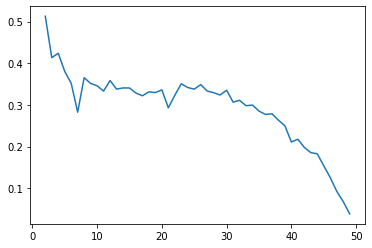

In [143]:
plt.plot(range(2,maxClusters),silh)

In [20]:
#K-Means Clustering

kmeans = KMeans(n_clusters=5, random_state=0).fit(dfNorm)

In [21]:
df=df.reset_index(drop=False)

In [22]:
clusters = pd.concat([df,pd.DataFrame(kmeans.labels_,columns=["Cluster"])],axis=1)
#clusterdf=pd.concat([clusterdf,state], axis=1, join='outer', ignore_index=True)
print(clusters)

   state     request    payment  percentage  Cluster
0     AK  273.804082  42.152509    0.153951        4
1     AL  203.490053  38.834243    0.190841        4
2     AR  130.618278  29.158509    0.223235        0
3     AZ  141.722734  30.384139    0.214391        3
4     CA  237.976007  33.132082    0.139224        1
5     CO  144.110738  30.986752    0.215020        3
6     CT  158.257680  32.490538    0.205301        3
7     DE  105.479530  21.589237    0.204677        0
8     FL  179.341887  34.173478    0.190549        3
9     GA  208.027100  35.499580    0.170649        4
10    HI  186.092695  31.055235    0.166880        2
11    IA  146.989728  26.869013    0.182795        2
12    ID  100.887345  29.181308    0.289246        0
13    IL  222.283632  33.991727    0.152921        4
14    IN  159.931961  31.696518    0.198188        3
15    KS  131.458248  28.476571    0.216621        0
16    KY  207.838672  36.915601    0.177617        4
17    LA  165.411541  30.189983    0.182514   

In [23]:
pd.set_option('display.max_rows', None)
display(clusters)

,state,request,payment,percentage,Cluster
0,AK,273.804082,42.152509,0.153951,4
1,AL,203.490053,38.834243,0.190841,4
2,AR,130.618278,29.158509,0.223235,0
3,AZ,141.722734,30.384139,0.214391,3
4,CA,237.976007,33.132082,0.139224,1
5,CO,144.110738,30.986752,0.215020,3
6,CT,158.257680,32.490538,0.205301,3
7,DE,105.479530,21.589237,0.204677,0
8,FL,179.341887,34.173478,0.190549,3
9,GA,208.027100,35.499580,0.170649,4


In [24]:
clusters.groupby('Cluster').mean()

,request,payment,percentage
Cluster,,,
0,117.725284,27.727724,0.237358
1,262.111019,33.532973,0.130052
2,168.164889,28.202119,0.169116
3,156.380443,31.878918,0.204956
4,216.022990,36.240290,0.168705


In [25]:
clusters['Cluster'].value_counts()

3    17
4    10
2    10
0     7
1     6
Name: Cluster, dtype: int64

In [26]:
clusters.describe()

,request,payment,percentage,Cluster
count,50.000000,50.000000,50.000000,50.000000
mean,177.941789,31.633152,0.186086,2.340000
std,47.849499,3.628307,0.036407,1.318781
min,100.887345,21.589237,0.102670,0.000000
25%,144.511501,29.602623,0.161925,1.250000
50%,166.394147,31.036692,0.188700,3.000000
75%,203.713860,34.009290,0.209535,3.000000
max,343.652490,42.152509,0.289246,4.000000


In [27]:
clusters=clusters.sort_values('Cluster')

In [28]:
export_csv = clusters.to_csv (r'C:\Users\anna2\Desktop\IEMS 308\npitostates.csv', index = None, header=True)